In [13]:
import scipy.io

filename = 'data/sample.mat'
matdata = scipy.io.loadmat(filename)
matdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'eeg'])

In [4]:
eeg = matdata['eeg']
print(type(eeg))
eeg.shape

<class 'numpy.ndarray'>


(40, 9, 1250, 6)

In [12]:
eeg[1,1,0:4,1]

array([-2.46824456, -4.70702955,  0.78052014, -1.59276555])

In [322]:
len_gaze_s = 0.5
len_delay_s = 0.13
num_fbs = 2
is_ensemble = 0
alpha_ci = 0.05

In [38]:
fs = 250
len_shift_s = 0.5

In [227]:
import numpy as np

list_freqs = []
for i in range(5):
    for j in range(8):
        list_freqs.append(8+0.2*i+1*j)
num_targs = len(list_freqs)
list_labels = np.array(range(0,num_targs,1))
print(list_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [76]:
len_gaze_smpl = round(len_gaze_s*fs)
len_gaze_smpl

125

In [72]:
len_delay_smpl = round(len_delay_s*fs)
len_delay_smpl

32

In [73]:
len_sel_s = len_gaze_s + len_shift_s
len_sel_s

1.0

In [74]:
ci = 100*(1-alpha_ci)
ci

95.0

In [78]:
data_segment_smpl = list(range(len_delay_smpl, len_delay_smpl+len_gaze_smpl))
#data_segment_smpl

In [93]:
eeg_seg = eeg[:, :, data_segment_smpl, :]
eeg_seg.shape

(40, 9, 125, 6)

In [316]:
from scipy import signal

def filterbank(x, fs, fb_i):
    
    num_chans = x.shape[0]
    num_smpls = x.shape[1]
    if x.ndim > 2:
        num_trials = x.shape[2]
    else:
        num_trials = 1
    fs = fs/2
    
    passband = [6, 14, 22, 30, 38, 46, 54, 62, 70, 78]
    stopband = [4, 10, 16, 24, 32, 40, 48, 56, 64, 72]
    Wp = [passband[fb_i]/fs, 90/fs]
    Ws = [stopband[fb_i]/fs, 100/fs]
    gpass = 3
    gstop = 40
    Rp = 0.5
    [N, Wn] = signal.cheb1ord(Wp, Ws, gpass, gstop)
    [B,A] = signal.cheby1(N, Rp, Wn, 'bandpass')
    
    if num_trials == 1:
        y = np.zeros((num_chans, num_smpls))
        for ch_i in range(num_chans):
            y[ch_i,:] = signal.filtfilt(B, A, x[ch_i,:])
    else:
        y = np.zeros((num_chans, num_smpls, num_trials))
        for trial_i in range(num_trials):
            for ch_i in range(num_chans):
                y[ch_i,:,trial_i] = signal.filtfilt(B, A, x[ch_i,:,trial_i])
    
    return y

In [254]:
from numpy import linalg as la

def ftrca(x):
    
    num_chans = x.shape[0]
    num_smpls = x.shape[1]
    num_trials = x.shape[2]
    
    for trial_i in range(num_trials):
        x1 = x[:,:,trial_i]
        x[:,:,trial_i] = x1 - x1.mean(axis=1, keepdims=True)
    
    SX = np.sum(x, axis=2)
    S = np.dot(SX,SX.T)
    QX = x.reshape(x.shape[0], -1)
    Q = np.dot(QX,QX.T)
    W, V = la.eig(np.dot(la.inv(Q), S))
    
    idx = W.argsort()[::-1]
    V = V[:,idx]
    
    return V

In [290]:
def train_trca(eeg, fs, num_fbs):
    
    num_targs = eeg.shape[0]
    num_chans = eeg.shape[1]
    num_smpls = eeg.shape[2]
    
    weight = np.zeros((num_targs, num_chans, num_fbs))
    train_temp = np.zeros((num_targs, num_chans, num_smpls, num_fbs))
    for targ_i in range(num_targs):
        #eeg_tmp = eeg[targ_i,:,:,:]
        for fb_i in range(num_fbs):
            traindata = filterbank(eeg[targ_i,:,:,:], fs, fb_i)
            w_tmp = ftrca(traindata)
            weight[targ_i,:,fb_i] = w_tmp[:,1]
            train_temp[targ_i,:,:,fb_i] = np.average(traindata, axis=2)

    #print(train_temp.shape)
        
    return weight, train_temp

In [312]:
from scipy.stats import pearsonr

def test_trca(eeg, weight, template, num_fbs, is_ensemble):

    num_targs = eeg.shape[0]
    num_chans = eeg.shape[1]
    num_smpls = eeg.shape[2]
    fb_coefs = pow(np.array(range(1,num_fbs+1,1)),-1.25)+0.25
    
    outclass = np.zeros(num_targs)
    for targ_i in range(num_targs):
        #testdata = eeg[targ_i,:,:]
        corr = np.zeros((num_targs, num_fbs))
        for fb_i in range(num_fbs):
            testdata = filterbank(eeg[targ_i,:,:], fs, fb_i)
            for class_i in range(num_targs): 
                traindata = template[class_i,:,:,fb_i]
                if is_ensemble:
                    w = weight[:,:,fb_i]
                else:
                    w = weight[class_i,:,fb_i]
                #corr, _ = pearsonr(np.dot(w.T,testdata), np.dot(w.T,traindata))
                #print(corr)
                #print(res)
                corr[class_i,fb_i], _ = pearsonr(np.dot(w,testdata), np.dot(w,traindata))
        #print(corr)
        #print(np.argmax(corr))
        rho = np.dot(fb_coefs, corr.T)
        #print(rho)
        outclass[targ_i] = np.argmax(rho)
    
    return outclass

[55 65 62 57 62 62]


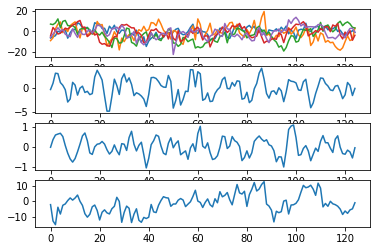

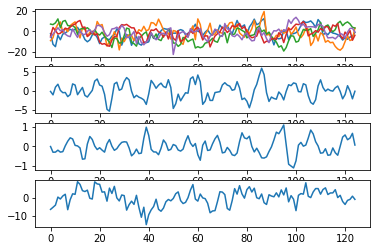

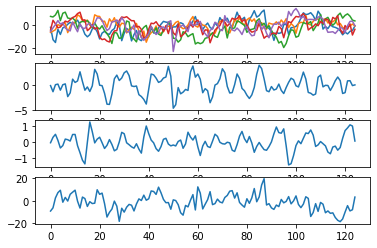

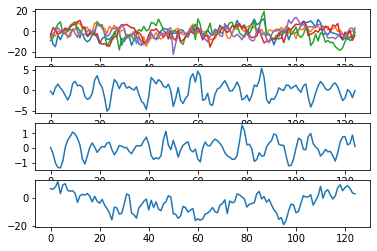

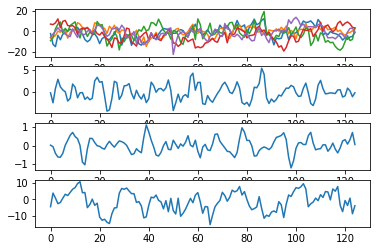

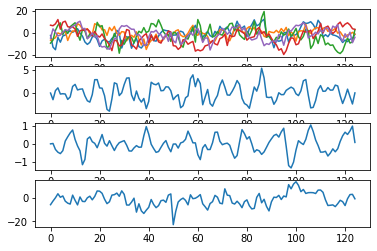

In [323]:
import matplotlib.pyplot as plt

num_trials = eeg_seg.shape[3]

accuracy = np.array(range(num_trials))
itr = np.array(range(num_trials))
for loocv_i in range(num_trials ):
    traindata = np.delete(eeg_seg, loocv_i, 3)
    weight, train_temp = train_trca(traindata, fs, num_fbs)
    
    fig, ax = plt.subplots(4)
    ax[0].plot(traindata[1,1,:,:])
    ax[1].plot(train_temp[1,1,:,1])
    ax[2].plot(np.dot(weight[1,:,1], train_temp[1,:,:,1]))
    
    testdata = eeg_seg[:,:,:,loocv_i]
    result = test_trca(testdata, weight, train_temp, num_fbs, is_ensemble)
    ax[3].plot(testdata[1,1,:])
    #print(result)
    
    #print(list_labels==result)
    is_correct = list_labels==result
    accuracy[loocv_i] = is_correct.mean()*100
    
print(accuracy)
    
    

array([1.25      , 0.67044821, 0.50327856, 0.4267767 , 0.38374806])